# Examples

Here we implement the models given in the `Examples` section.

In [1]:
import arviz as az
import fybdthemes
import jax
import numpy as np
import optax
import sbijax
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

from matplotlib.ticker import AutoLocator, MaxNLocator
from jax import numpy as jnp, random as jr
from jax._src.flatten_util import ravel_pytree
from tensorflow_probability.substrates.jax import distributions as tfd

We implement a custom function to visualize posterior pairs.

In [2]:
def plot_posteriors(obj, save_path=None):
    _, axes = plt.subplots(figsize=(12, 10), nrows=5, ncols=5)
    with az.style.context(["arviz-doc"], after_reset=True):
        for i in range(0, 5):        
            for j in range(0, 5):
                ax = axes[i, j]
                if i < j:
                    ax.axis('off')
                else:
                    ax.hexbin(obj[..., j], obj[..., i], gridsize=50, bins='log', cmap='viridis')            
                ax.spines.left.set_linewidth(.5)
                ax.spines.bottom.set_linewidth(.5)
                ax.spines.right.set_linewidth(.5)
                ax.spines.top.set_linewidth(.5)       
                ax.xaxis.set_major_locator(MaxNLocator(2))
                ax.yaxis.set_major_locator(MaxNLocator(2))
                ax.xaxis.set_tick_params(width=1, length=2, labelsize=25)
                ax.yaxis.set_tick_params(width=1, length=2, labelsize=25)
                if i < 4:                    
                    ax.set_xticklabels([])
                    ax.xaxis.set_tick_params(width=0., length=0)
                if j != 0:                    
                    ax.set_yticklabels([])
                    ax.yaxis.set_tick_params(width=0., length=0)
                ax.grid(which='major', axis='both', alpha=0.5)
        for i in range(5):
            axes[i, i].hist(obj[..., i], color="black")
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

We then define the generative model.

In [3]:
def prior_fn():
    prior = tfd.JointDistributionNamed(dict(
        theta=tfd.Uniform(jnp.full(5, -3.0), jnp.full(5, 3.0))
    ), batch_ndims=0)
    return prior


def simulator_fn(seed, theta):
    theta = theta["theta"]
    orig_shape = theta.shape
    if theta.ndim == 2:
        theta = theta[:, None, :]
    us_key, noise_key = jr.split(seed)

    def _unpack_params(ps):
        m0 = ps[..., [0]]
        m1 = ps[..., [1]]
        s0 = ps[..., [2]] ** 2
        s1 = ps[..., [3]] ** 2
        r = jnp.tanh(ps[..., [4]])
        return m0, m1, s0, s1, r

    m0, m1, s0, s1, r = _unpack_params(theta)
    us = tfd.Normal(0.0, 1.0).sample(
        seed=us_key, sample_shape=(theta.shape[0], theta.shape[1], 4, 2)
    )
    xs = jnp.empty_like(us)
    xs = xs.at[:, :, :, 0].set(s0 * us[:, :, :, 0] + m0)
    y = xs.at[:, :, :, 1].set(
        s1 * (r * us[:, :, :, 0] + jnp.sqrt(1.0 - r**2) * us[:, :, :, 1]) + m1
    )
    if len(orig_shape) == 2:
        y = y.reshape((*theta.shape[:1], 8))
    else:
        y = y.reshape((*theta.shape[:2], 8))
    return y

In [4]:
y_obs = jnp.array([[
    -0.9707123,
    -2.9461224,
    -0.4494722,
    -3.4231849,
    -0.13285634,
    -3.364017,
    -0.85367596,
    -2.4271638,
]])

### MCMC

In [5]:
from functools import partial
from jax import scipy as jsp
from sbijax import as_inference_data
from sbijax.mcmc import sample_with_nuts, sample_with_slice

In [6]:
def likelihood_fn(theta, y):
    mu = jnp.tile(theta[:2], 4)
    s1, s2 = theta[2] ** 2, theta[3] ** 2
    corr = s1 * s2 * jnp.tanh(theta[4])
    cov = jnp.array([[s1**2, corr], [corr, s2**2]])
    cov = jsp.linalg.block_diag(*[cov for _ in range(4)])
    p = tfd.MultivariateNormalFullCovariance(mu, cov)
    return p.log_prob(y)


def log_density_fn(theta, y):
    prior_lp = tfd.JointDistributionNamed(dict(
        theta=tfd.Uniform(jnp.full(5, -3.0), jnp.full(5, 3.0))
    )).log_prob(theta)
    likelihood_lp = likelihood_fn(theta, y)
    lp = jnp.sum(prior_lp) + jnp.sum(likelihood_lp)
    return lp

In [7]:
log_density = partial(log_density_fn, y=y_obs)

def lp(theta):
    return jax.vmap(log_density)(theta)

slice_samples = sample_with_slice(
    jr.PRNGKey(0),
    lp,
    prior_fn().sample,
    n_chains=10, 
    n_samples=10_000, 
    n_warmup=5_000
)

/Users/simon/miniconda3/envs/sbi-dev/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/Users/simon/miniconda3/envs/sbi-dev/lib/python3.9/site-packages/tensorflow_probability/python/internal/backend/jax/ops.py:339: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return np.array(value, dtype=dtype)
/Users/simon/miniconda3/envs/sbi-dev/lib/python3.9

In [8]:
slice_inference_data = as_inference_data({"theta": slice_samples.reshape(10, 5000, 5)}, y_obs)

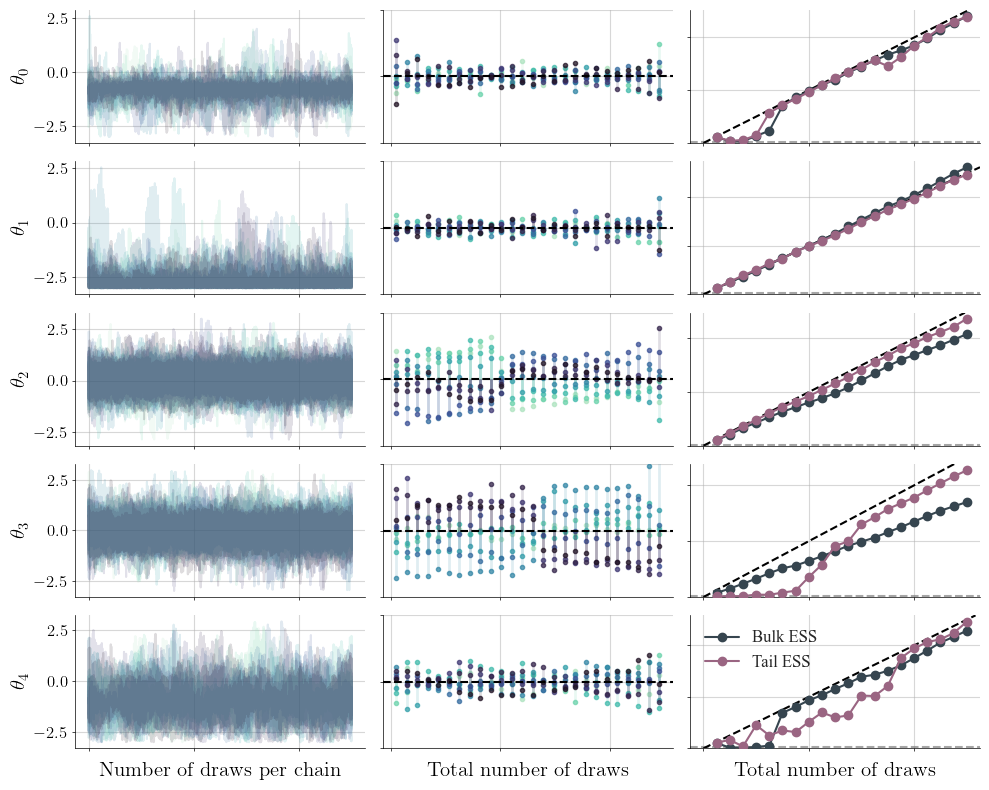

In [9]:
def plot_ess_and_trace(inference_results):
    _, axes = plt.subplots(figsize=(10, 8), nrows=5, ncols=3)

    with az.style.context(["arviz-doc", "arviz-viridish"], after_reset=True):
        plt.rcParams["font.family"] = "Times New Roman"        
        colors = sns.color_palette("ch:s=-.2,r=.6", as_cmap=False, n_colors=10, desat=.8)
        ax = az.plot_ess(
            inference_results,
            ax=[axes[i, 2] for i in range(5)], 
            color="#36454F",
            extra_kwargs={"color": list(colors[-5])},
            kind="evolution"
        )
        for ax in [axes[i, 2] for i in range(5)]:
            ax.axline((0, 0), slope=1, color="black", ls="--")
        colors = sns.color_palette("mako_r", as_cmap=False, n_colors=10)        
        az.plot_rank(inference_results, ax=[axes[i, 1] for i in range(5)],  kind='vlines', colors=colors, vlines_kwargs={"alpha":0.15}, marker_vlines_kwargs={"linestyle":'None', "marker": "o", "ms":3, "alpha": 0.75})        
        for i in range(5):
            for j in range(10):
                axes[i, 0].plot(slice_samples.reshape(10, 5000, 5)[j, :, i], color=colors[j], alpha=0.15)                
                axes[i, 0].set_ylabel(rf"$\theta_{i}$", fontsize=15)              
                axes[i, 1].set_ylabel(None)
                axes[i, 2].set_ylabel(None)        
        for i, ax in enumerate(axes.flatten()):
            ax.set_title(None)
            ax.spines[['right', 'top']].set_visible(False)            
            ax.spines.left.set_linewidth(.5)
            ax.spines.bottom.set_linewidth(.5)
            ax.yaxis.set_major_locator(AutoLocator())                                    
            ax.set_xlabel(None)
            if i in [13, 14]:
                ax.set_xlabel("Total number of draws", fontsize=15)
            if i == 12:
                ax.set_xlabel("Number of draws per chain", fontsize=15)
            if ax.get_legend() is not None:
                ax.get_legend().remove()            
            #ax.legend(bbox_to_anchor=(0.95, .7), frameon=False)
            ax.yaxis.set_tick_params(labelsize=12)
            ax.xaxis.set_tick_params(labelsize=12)
            ax.xaxis.set_tick_params(width=0.5, length=2)
            ax.yaxis.set_tick_params(width=0.5, length=2)
            ax.grid(which='major', axis='both', alpha=0.5)
            if i != [12,13,14]:                    
                ax.set_xticklabels([])
            if i in [2,5,8,11,14]:
                ax.set_yticklabels([])
            axes[4, 2].legend(["Bulk ESS", "Tail ESS"], fontsize=12)
    plt.tight_layout()
    plt.show()
    
plot_ess_and_trace(slice_inference_data)

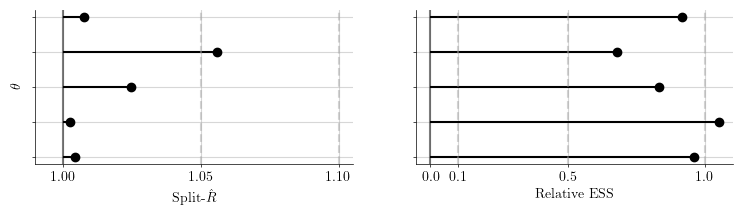

In [10]:
_, axes = plt.subplots(figsize=(9, 2), ncols=2)
sbijax.plot_rhat_and_ress(slice_inference_data, axes=axes)
plt.show()

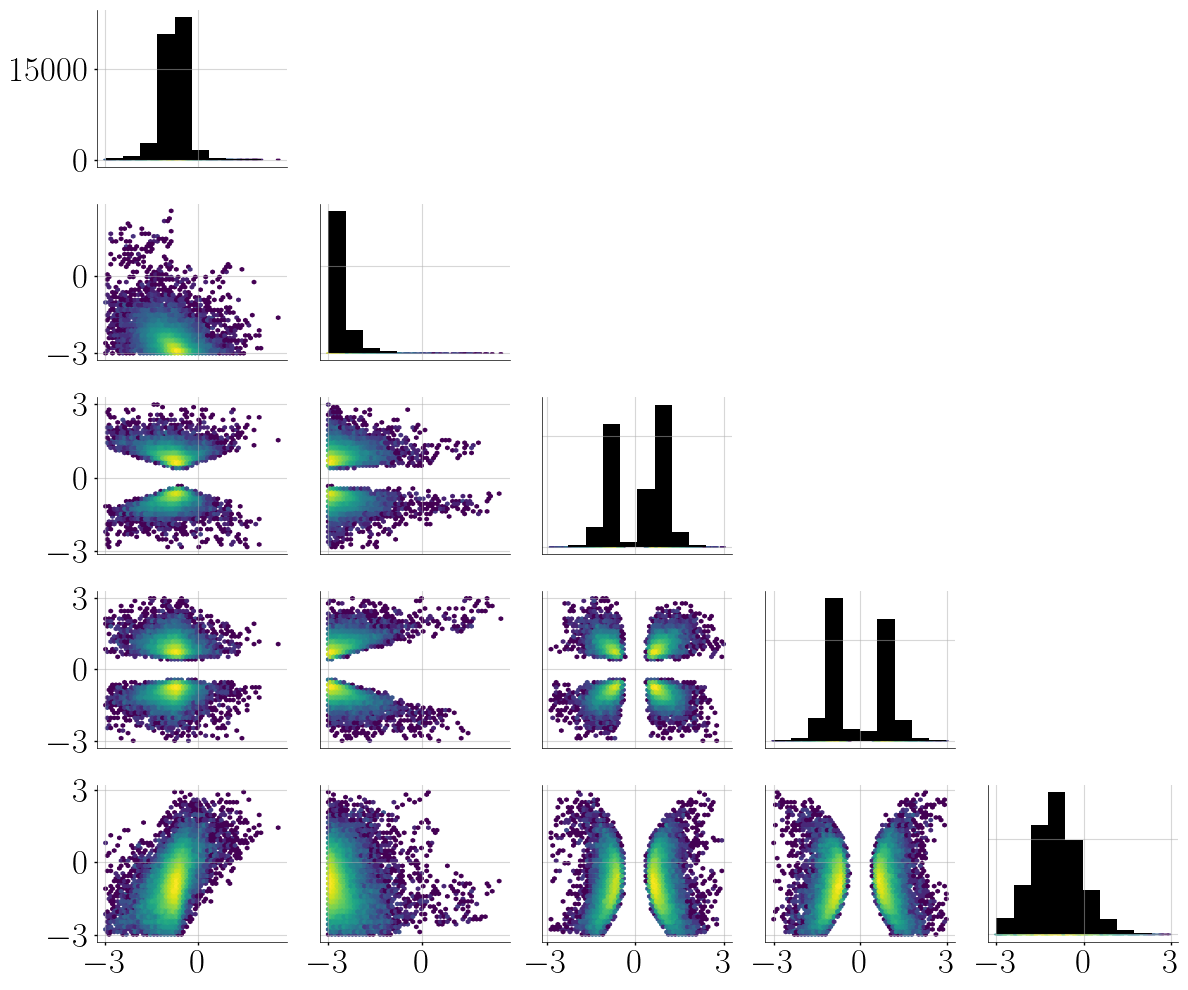

In [11]:
plot_posteriors(slice_samples.reshape(-1, 5))

### SNLE

In [12]:
from sbijax import SNLE, inference_data_as_dictionary
from sbijax.nn import make_maf

In [13]:
n_dim_data = y_obs.shape[-1]

n_layer_dimensions, hidden_sizes = (8, 8, 5, 5, 5), (64, 64)
neural_network = make_maf(n_dim_data, n_layer_dimensions=n_layer_dimensions, hidden_sizes=hidden_sizes)

fns = prior_fn, simulator_fn
nle = SNLE(fns, neural_network)

In [14]:
data, nle_params = None, {}
for i in range(15):
    data, _ = nle.simulate_data_and_possibly_append(
        jr.fold_in(jr.PRNGKey(1), i),
        params=nle_params,
        observable=y_obs,
        data=data,
    )
    nle_params, info = nle.fit(
        jr.fold_in(jr.PRNGKey(2), i), data=data
    )

 32%|██████████████████████████████████████████████████████████████▊                                                                                                                                    | 322/1000 [02:01<04:15,  2.66it/s]


In [15]:
nle_inference_results, diagnostics = nle.sample_posterior(
    jr.PRNGKey(1), nle_params, y_obs, n_samples=10_000, n_warmup=5000, n_chains=5
)

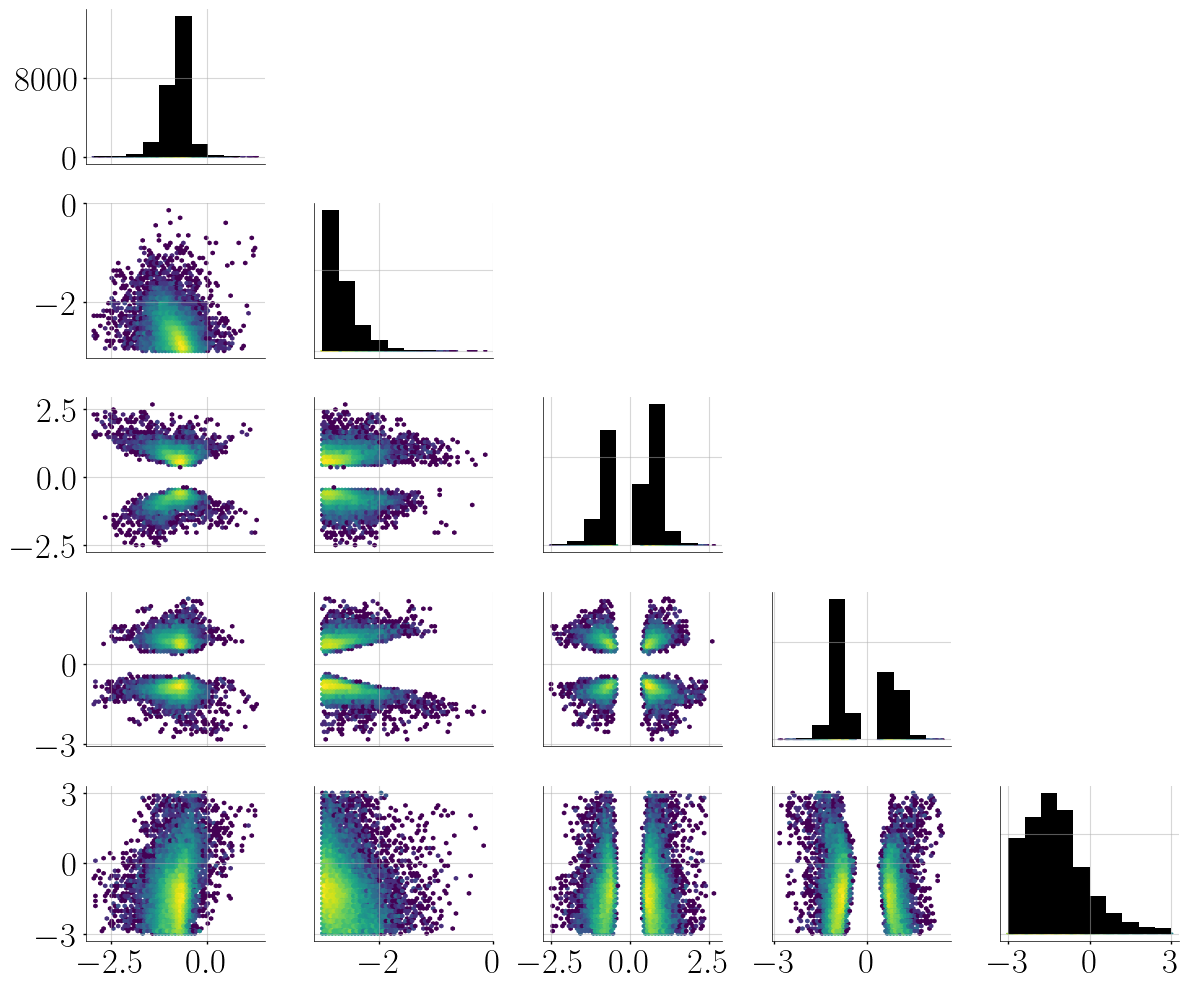

In [16]:
plot_posteriors(
    inference_data_as_dictionary(nle_inference_results.posterior)["theta"],
)

### FMPE

In [17]:
from sbijax import FMPE
from sbijax.nn import make_cnf

In [18]:
n_dim_theta = 5
n_layers, hidden_size = 5, 128
neural_network = make_cnf(n_dim_theta, n_layers, hidden_size)

fns = prior_fn, simulator_fn
fmpe = FMPE(fns, neural_network)

In [19]:
data, _ = fmpe.simulate_data(
    jr.fold_in(jr.PRNGKey(1), i),
    n_simulations=20_000,
)
fmpe_params, info = fmpe.fit(
    jr.fold_in(jr.PRNGKey(2), i),
    data=data, 
    optimizer=optax.adam(0.001), 
    n_early_stopping_delta=0.00001, 
    n_early_stopping_patience=30
)

 10%|████████████████████▍                                                                                                                                                                              | 105/1000 [01:44<14:52,  1.00it/s]


In [20]:
fmpe_inference_results, diagnostics = fmpe.sample_posterior(
    jr.PRNGKey(1), fmpe_params, y_obs, n_samples=25_000
)

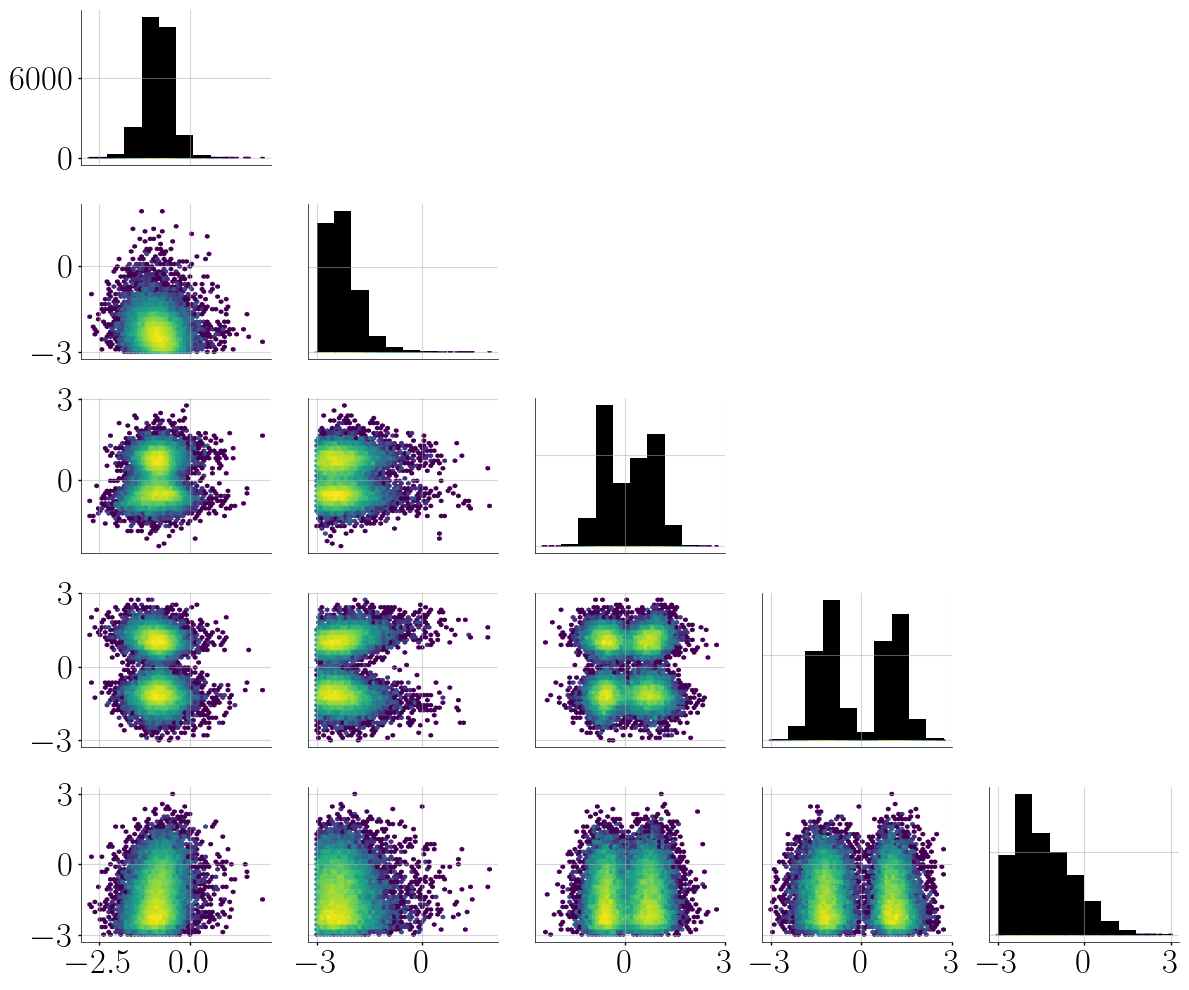

In [21]:
plot_posteriors(
    inference_data_as_dictionary(fmpe_inference_results.posterior)["theta"],
)

### SMC-ABC

In [22]:
from sbijax import NASS, SMCABC, inference_data_as_dictionary
from sbijax.nn import make_nass_net

In [23]:
n_embedding_dim, hidden_sizes = 5, (64, 64)
neural_network = make_nass_net(n_embedding_dim, hidden_sizes)

fns = prior_fn, simulator_fn
model_nass = NASS(fns, neural_network)

data, _ = model_nass.simulate_data(jr.PRNGKey(1), n_simulations=20_000)
params_nass, _ = model_nass.fit(jr.PRNGKey(2), data=data, n_early_stopping_patience=25)

 20%|██████████████████████████████████████▏                                                                                                                                                            | 196/1000 [02:37<10:45,  1.25it/s]


In [24]:
def distance_fn(y_simulated, y_observed):
    diff = y_simulated - y_observed
    dist = jax.vmap(lambda el: jnp.linalg.norm(el))(diff)
    return dist

def summary_fn(y):
    s = model_nass.summarize(params_nass, y)
    return s

model_smc = SMCABC(fns, summary_fn, distance_fn)

In [25]:
smc_inference_results, _ = model_smc.sample_posterior(
    jr.PRNGKey(3),
    y_obs,
    n_rounds=2, 
    n_particles=5_000, 
    eps_step=0.825, 
    ess_min=2_000
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:07<00:00, 33.56s/it]


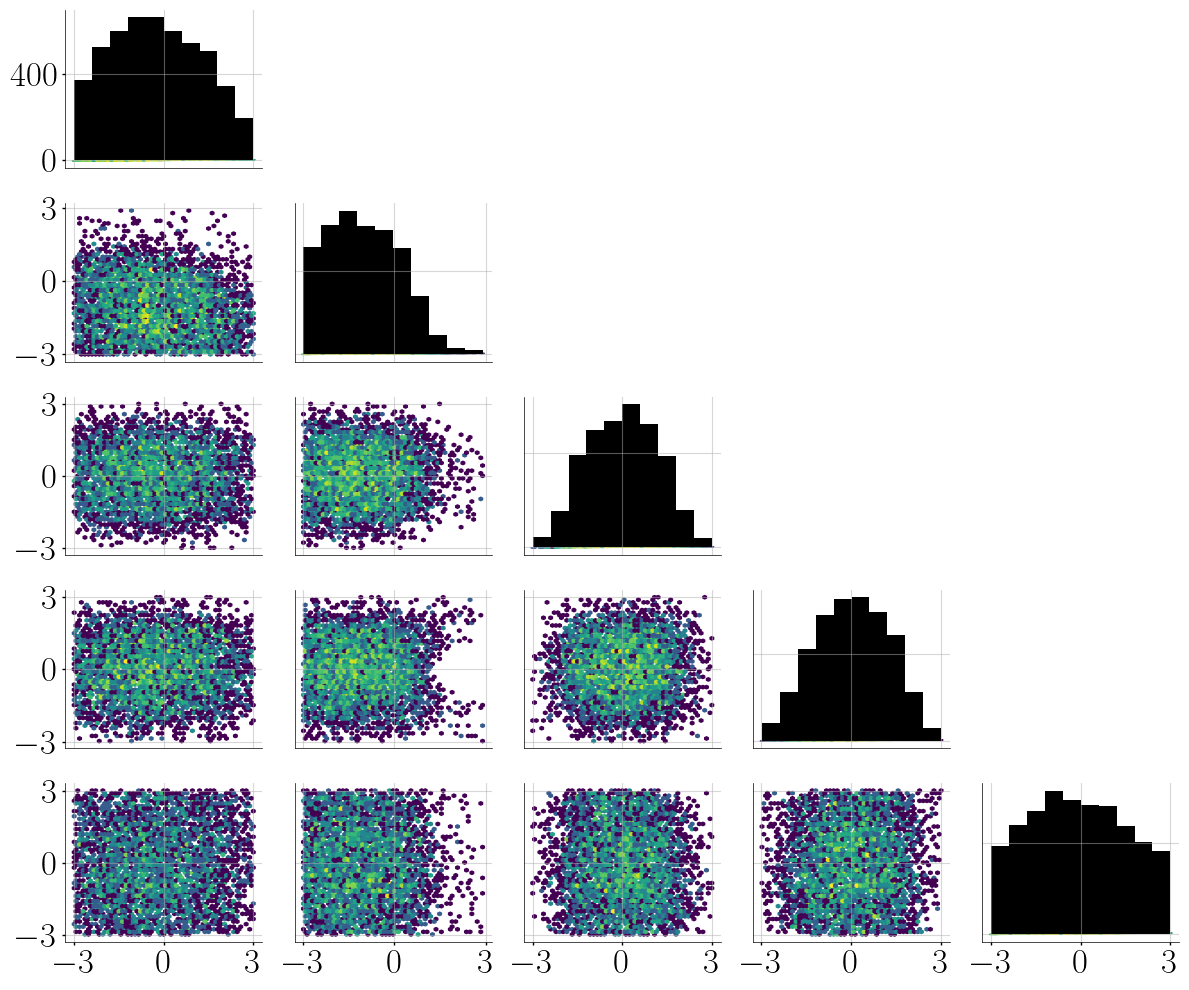

In [26]:
plot_posteriors(
    inference_data_as_dictionary(smc_inference_results.posterior)["theta"],
)

## Session info

In [27]:
import session_info

session_info.show(html=False)

-----
arviz                       0.17.1
fybdthemes                  0.1.2
haiku                       0.0.11
jax                         0.4.24
jaxlib                      0.4.24
matplotlib                  3.6.2
numpy                       1.24.1
optax                       0.1.7
sbijax                      1.0.0
seaborn                     0.12.2
session_info                1.0.0
tensorflow_probability      0.24.0-dev20240224
-----
IPython             8.8.0
jupyter_client      7.4.9
jupyter_core        5.1.3
jupyterlab          3.5.2
notebook            6.5.2
-----
Python 3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:48:25) [Clang 14.0.6 ]
macOS-13.0.1-arm64-arm-64bit
-----
Session information updated at 2024-08-15 11:55
